In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/DataSet"

combined_chest_pn_covid


In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()

import tensorflow as tf
%matplotlib inline

from keras.models import Sequential
from keras.models import model_from_json

In [ ]:
# Set the seed for hash based operations in python
# os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
# np.random.seed(111)

# Disable multi-threading in tensorflow ops
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
# tf.set_random_seed(111)

# Define a tensorflow session with above session configs
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
# K.set_session(sess)

# Make the augmentation sequence deterministic
# aug.seed(111)

In [ ]:
# Define path to the data directory
data_dir = Path('/content/gdrive/My Drive/DataSet/combined_chest_pn_covid')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

# Path to validation directory
val_dir = data_dir / 'val'

In [ ]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
COVID_cases_dir = train_dir / 'COVID'

print(pneumonia_cases_dir)
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
COVID_cases = COVID_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in COVID_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

print(np.array(train_data).shape)

/content/gdrive/My Drive/DataSet/combined_chest_pn_covid/train/PNEUMONIA
(6162, 2)


In [ ]:
# Get the path to the normal and pneumonia sub-directories
valid_normal_cases_dir = val_dir / 'NORMAL'
valid_pneumonia_cases_dir = val_dir / 'PNEUMONIA'
valid_COVID_cases_dir = val_dir / 'COVID'

# Get the list of all the images
valid_normal_cases = valid_normal_cases_dir.glob('*.jpeg')
valid_pneumonia_cases = valid_pneumonia_cases_dir.glob('*.jpeg')
valid_COVID_cases = valid_COVID_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
valid_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in valid_normal_cases:
    valid_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in valid_pneumonia_cases:
    valid_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in valid_COVID_cases:
    valid_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
valid_data = pd.DataFrame(valid_data, columns=['image', 'label'],index=None)

# Shuffle the data 
valid_data = valid_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
valid_data.head()

print(np.array(valid_data).shape)


(24, 2)


In [ ]:
# Get the path to the normal and pneumonia sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'
test_COVID_cases_dir = test_dir / 'COVID'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')
test_COVID_cases = test_COVID_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in test_COVID_cases:
    test_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,/content/gdrive/My Drive/DataSet/combined_ches...,0
1,/content/gdrive/My Drive/DataSet/combined_ches...,1
2,/content/gdrive/My Drive/DataSet/combined_ches...,1
3,/content/gdrive/My Drive/DataSet/combined_ches...,0
4,/content/gdrive/My Drive/DataSet/combined_ches...,1


1    390
2    336
0    234
Name: label, dtype: int64


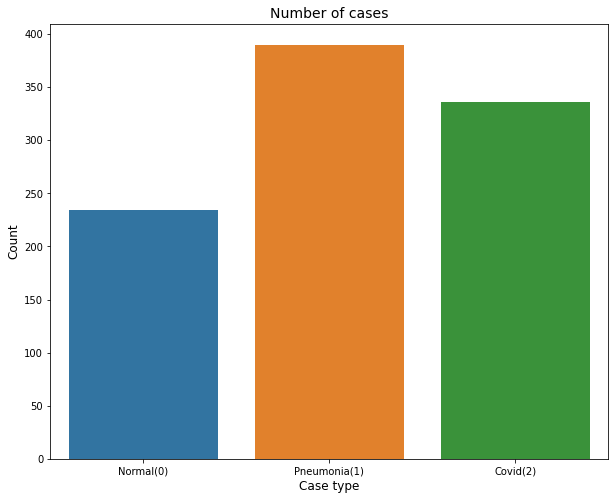

In [ ]:
# Get the counts for each class
cases_count2 = test_data['label'].value_counts()
print(cases_count2)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count2.index, y= cases_count2.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count2.index)), ['Normal(0)', 'Pneumonia(1)','Covid(2)'])
plt.show()

2    8
1    8
0    8
Name: label, dtype: int64


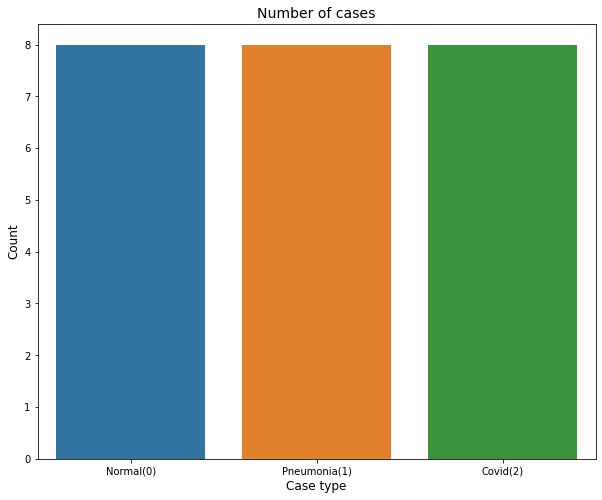

In [ ]:
# Get the counts for each class
cases_count1 = valid_data['label'].value_counts()
print(cases_count1)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count1.index, y= cases_count1.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count1.index)), ['Normal(0)', 'Pneumonia(1)','Covid(2)'])
plt.show()

1    3842
0    1341
2     979
Name: label, dtype: int64


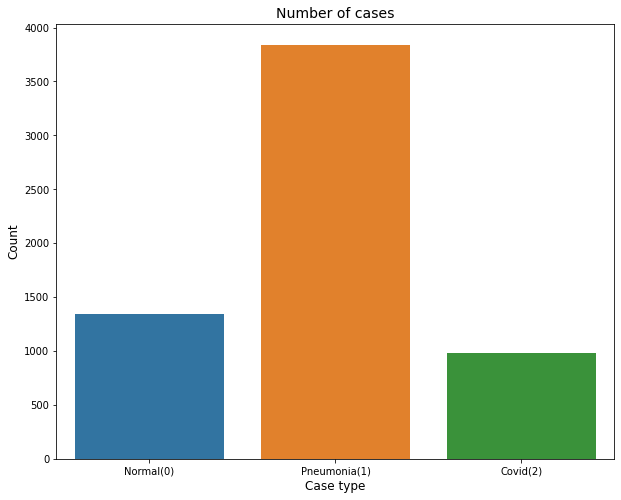

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)','Covid(2)'])
plt.show()

In [ ]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'
COVID_cases_dir = val_dir / 'COVID'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
COVID_cases = COVID_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)

# Covid cases        
for img in COVID_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)

# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (24, 224, 224, 3)
Total number of labels: (24, 3)


In [ ]:
# Get the path to the sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'
test_COVID_cases_dir = test_dir / 'COVID'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')
test_COVID_cases = test_COVID_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
test_data = []
test_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in test_normal_cases:
 
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
                      
# Pneumonia cases        
for img in test_pneumonia_cases:
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    test_data.append(img)
    test_labels.append(label)

# Covid cases        
for img in test_COVID_cases:
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    test_data.append(img)
    test_labels.append(label)   
    
# Convert the list into numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of Testing examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of Testing examples:  (960, 224, 224, 3)
Total number of labels: (960, 3)


In [ ]:
# Get the path to the sub-directories
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'
train_COVID_cases_dir = train_dir / 'COVID'

# Get the list of all the images
train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')
train_COVID_cases = train_COVID_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
train_data = []
train_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in train_normal_cases:
 
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    train_data.append(img)
    train_labels.append(label)
                      
# Pneumonia cases        
for img in train_pneumonia_cases:
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    train_data.append(img)
    train_labels.append(label)

# Covid cases        
for img in train_COVID_cases:
    
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    train_data.append(img)
    train_labels.append(label)   
    
# Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of training examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of training examples:  (6162, 224, 224, 3)
Total number of labels: (6162, 3)


In [ ]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,3), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [ ]:
import keras 
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal



full_name='concatenate'
classes_number=3 #Number of classes
input_tensor=Input(shape=(224,224,3))
######################################################################################################
base_model1 = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
features1 = base_model1.output
######################################################################################################
base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
features2 = base_model2.output
concatenated=keras.layers.concatenate([features1,features2]) #Concatenate the extracted features
####################################################################################################
conv=keras.layers.Conv2D(1024, (1, 1),padding='same')(concatenated) #add the concatenated features to a convolutional layer
feature = Flatten(name='flatten')(conv)
dp = Dropout(0.5)(feature) #add dropout
preds = Dense(classes_number, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp) 
Concatenated_model = Model(inputs=input_tensor, outputs=preds)
#######################################################
for layer in Concatenated_model.layers:
  layer.trainable = True
opt=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
# opt = Nadam(lr=0.0001, decay=1e-5)
Concatenated_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#ModelCheckpoint callback saves a model at some interval. 
filepath="gdrive/My Drive/models_details/xception_Resnet50V2/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv]


In [ ]:
Concatenated_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
batch_size = 16
nb_epochs = 10

testing_batch_size = 4
testing_nb_epochs = 5
# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)
# Get a val data generator
val_data_gen = data_gen(data=valid_data, batch_size=batch_size)

# Get a test data generator
test_data_gen = data_gen(data=test_data, batch_size=testing_batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size
# Define the number of validating steps
nb_val_steps = valid_data.shape[0]//batch_size

# Define the number of testing steps
nb_test_steps = test_data.shape[0]//testing_batch_size


print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))
print("Number of testing and validation steps: {} and {}".format(nb_test_steps, len(valid_data)))

Number of training and validation steps: 385 and 24
Number of testing and validation steps: 240 and 24


In [ ]:
print(np.array(train_data).shape)
print(np.array(valid_data).shape)
print(np.array(valid_labels).shape)

(6162, 224, 224, 3)
(24, 224, 224, 3)
(24, 3)


In [ ]:
history = Concatenated_model.fit(train_data,train_labels, epochs=nb_epochs, steps_per_epoch=nb_train_steps,validation_data=(valid_data, valid_labels),validation_steps=nb_val_steps,callbacks=callbacks_list)

Epoch 1/10
385/385 [==============================] - ETA: 0s - loss: 4.9458 - accuracy: 0.7749
Epoch 00001: val_accuracy improved from -inf to 0.54167, saving model to gdrive/My Drive/models_details/xception_Resnet50V2/weights-improvement-01-0.54.hdf5
385/385 [==============================] - 482s 1s/step - loss: 4.9458 - accuracy: 0.7749 - val_loss: 395.7117 - val_accuracy: 0.5417
Epoch 2/10
385/385 [==============================] - ETA: 0s - loss: 2.4574 - accuracy: 0.8752
Epoch 00002: val_accuracy improved from 0.54167 to 0.58333, saving model to gdrive/My Drive/models_details/xception_Resnet50V2/weights-improvement-02-0.58.hdf5
385/385 [==============================] - 481s 1s/step - loss: 2.4574 - accuracy: 0.8752 - val_loss: 28.2667 - val_accuracy: 0.5833
Epoch 3/10
385/385 [==============================] - ETA: 0s - loss: 2.8368 - accuracy: 0.8892
Epoch 00003: val_accuracy improved from 0.58333 to 0.83333, saving model to gdrive/My Drive/models_details/xception_Resnet50V2/w

In [ ]:
Concatenated_model.load_weights("/content/gdrive/My Drive/models_details/xception_Resnet50V2/weights-improvement-06-0.96.hdf5")

In [ ]:
history = model.fit(train_data,train_labels, epochs=nb_epochs, steps_per_epoch=nb_train_steps,validation_data=(valid_data, valid_labels),validation_steps=nb_val_steps,callbacks=callbacks_list)

In [ ]:
model.save('chest_classification_model.h5')  # always save your weights after training or during training

In [ ]:
# Get predictions
preds = Concatenated_model.predict(valid_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(valid_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)


# Get predictions
preds_test = Concatenated_model.predict(test_data, batch_size=16)
preds_test = np.argmax(preds_test, axis=-1)

# Original labels
orig_test_labels_1 = np.argmax(test_labels, axis=-1)

# print(orig_test_labels_1.shape)
# print(preds_test.shape)
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels_1, preds_test)
print(cm)


(24,)
(24,)
[[135  96   3]
 [ 24 366   0]
 [  1   6 329]]


In [ ]:
# Evaluation on test dataset
test_loss, test_score = Concatenated_model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

60/60 [==============================] - 15s 256ms/step - loss: 1.6267 - accuracy: 0.8646
Loss on test set:  1.6267379522323608
Accuracy on test set:  0.8645833134651184


<Figure size 432x288 with 0 Axes>

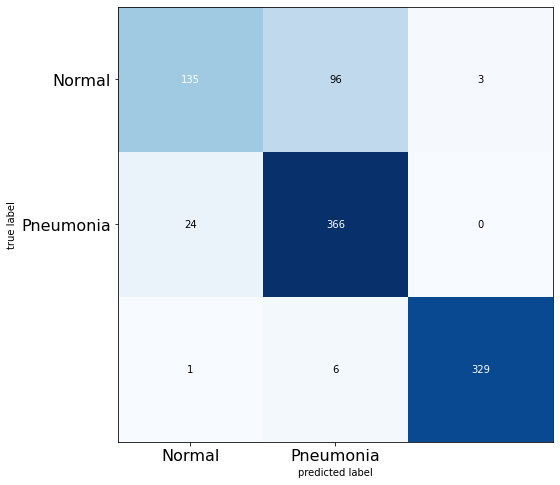

In [ ]:
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia','Covid'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia','Covid'], fontsize=16)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score

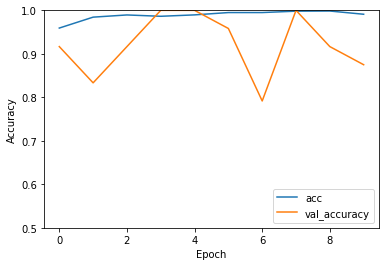

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)


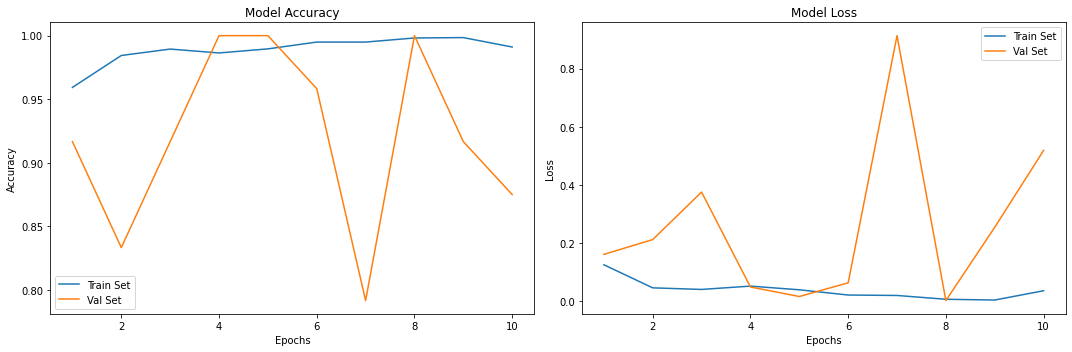

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()